In [22]:
import numpy as np 
import pandas as pd 
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_train = df_train.iloc[:, 1:]
Y_train = df_train.iloc[:, 0]

In [24]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [26]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# Normalize inputs
X_train = X_train / 255.0

In [27]:
def plot_digits(X, Y):
    for i in range(16):
        plt.subplot(5, 4, i+1)
        plt.tight_layout()
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title('Digit:{}'.format(Y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

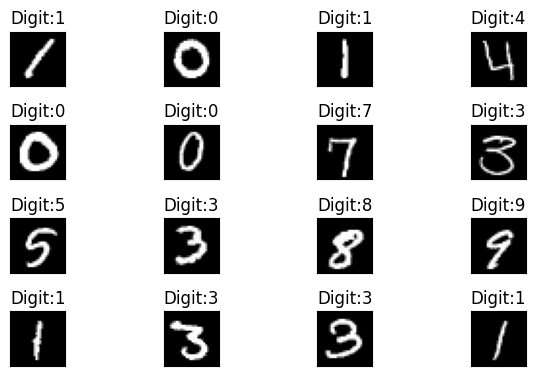

In [28]:
plot_digits(X_train, Y_train)

In [36]:
#Train-Test Split
X_dev, X_val, Y_dev, Y_val = train_test_split(X_train, Y_train, test_size=0.03, shuffle=True, random_state=2019)

In [37]:
T_dev = pd.get_dummies(Y_dev).values
T_val = pd.get_dummies(Y_val).values

In [38]:
#Reshape the input 
X_dev = X_dev.reshape(X_dev.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

In [39]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.build()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,174 (1.41 MB)

 Trainable params: 369,174 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
adam = Adam(learning_rate=5e-4)  
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)


In [41]:
# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)

In [47]:
datagen.fit(X_dev)
model.fit(datagen.flow(X_dev, T_dev, batch_size=100), steps_per_epoch=int(len(X_dev)/100), 
          epochs=30, validation_data=(X_val, T_val), callbacks=[reduce_lr])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


407/407 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.7171 - loss: 0.8715 - val_accuracy: 0.9667 - val_loss: 0.1378 - learning_rate: 5.0000e-04
Epoch 2/30
  1/407 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9100 - loss: 0.2468

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:97: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.9100 - loss: 0.1237 - val_accuracy: 0.9675 - val_loss: 0.1301 - learning_rate: 5.0000e-04
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.9478 - loss: 0.1653 - val_accuracy: 0.9738 - val_loss: 0.0898 - learning_rate: 5.0000e-04
Epoch 4/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.9600 - loss: 0.0473 - val_accuracy: 0.9746 - val_loss: 0.0852 - learning_rate: 5.0000e-04
Epoch 5/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.9654 - loss: 0.1078 - val_accuracy: 0.9825 - val_loss: 0.0654 - learning_rate: 5.0000e-04
Epoch 6/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.9700 - loss: 0.0563 - val_accuracy: 0.9802 - val_loss: 0.0689 - learning_rate: 5.0000e-04
Epoch 7/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.9719 - loss: 0.0875 - val_accuracy: 0.9889 - val_loss: 0.0515 - learning_rate: 5.0000e-04
Epoch 8/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accurac

In [48]:
score = model.evaluate(X_val, T_val, batch_size=32)
score

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9916 - loss: 0.0218


[0.048181574791669846, 0.9904761910438538]

In [50]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [51]:
X_test = np.array(df_test)
X_test = X_test/255.0

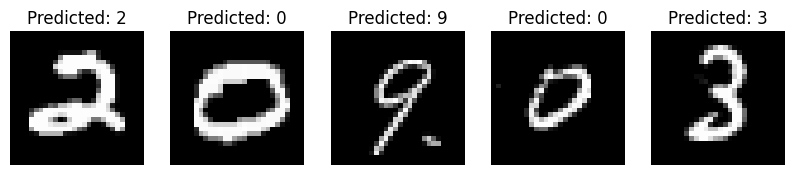

In [55]:
import matplotlib.pyplot as plt

# Define a function to display images and their predictions
def display_images(images, predictions, num_images=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {predictions[i]}', fontsize=12)
        plt.axis('off')
    plt.show()

# Display the first 5 images along with their predictions
display_images(X_test[:5], Y_test[:5])
